## **Set 3 (D Tasks) Analyse the learned representations**

Note: Since UMAP and `scikit-learn` conflict on my machine, I need to use Colab for this task. Therefore, I separated the notebook into a different `.ipynb` file.


### Import Modules

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt



### Process Data

- This code copied from task 1 and 2

In [ ]:
data_frame = pd.read_csv('data.csv')
# features selection (remove the patient ID column)
data_frame_processed = data_frame.drop(['record'], axis=1)
# label categorical data
data_frame_processed['type'] = LabelEncoder().fit_transform(data_frame_processed['type'])
# normalize data
scaler = StandardScaler()
feature_x_raw = data_frame_processed.drop(['type'], axis=1)
feature_x_scaled = pd.DataFrame(scaler.fit_transform(feature_x_raw), columns= feature_x_raw.columns)
target_y = data_frame_processed['type']
# split data to apply pca and balance data
x_all = feature_x_scaled.values.astype(np.float32)  # original scaled
y_all = target_y.values.astype(np.int64)
x_train_raw, x_temp, y_train_raw, y_temp = train_test_split(x_all, y_all, test_size=0.2, random_state=42, stratify=y_all) # float64 is highest type in the original features
x_val, x_test, y_val, y_test = train_test_split( x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) #because in the original data, the target column has type int64
#apply PCA on train data
pca = PCA(n_components=0.95, random_state=42) # keep 95%
x_train_pca = pca.fit_transform(x_train_raw) # find cosin before transform
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

# apply SMOTE only for training set, we should not apply SMOTE for test data
x_train_final, y_train_final = SMOTE(random_state=42).fit_resample(x_train_pca, y_train_raw)

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CustomDataset(x_train_final, y_train_final)
val_ds   = CustomDataset(x_val_pca, y_val)
test_ds  = CustomDataset(x_test_pca, y_test)
batch_size = 125
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

class TrainModel():
    def __init__(self, neural_model, device, criterion, optimizer, scheduler=None):
        self.neural_model = neural_model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler

    def train(self, train_loader):
        self.neural_model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad() #clear previous gradient
            output = self.neural_model(data)
            loss = self.criterion(output, target) #if confidence is high and prediction is wrong -> high penalty
            loss.backward()
            self.optimizer.step() #update weight

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.neural_model.eval() # switch to evaluation mode (turn OFF the dropout layers ...)
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.neural_model(data)
                val_loss += self.criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        return val_loss, val_acc

    def train_epoch(self, num_epochs, writer = None):
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        learning_rates = []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            val_loss, val_acc = self.validate(val_loader)

            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)  #  validation loss for ReduceLROnPlateau
                else:
                    self.scheduler.step()  #other schedulers
            #track learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            learning_rates.append(current_lr)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validate Loss: {val_loss:.4f}, Validate Acc: {val_acc:.2f}%')
            if writer is not None:
                if self.scheduler is not None:
                    writer.add_scalars('Loss_Comparison', {'Train': train_loss, 'Validation': val_loss}, epoch)
                    writer.add_scalars('Accuracy_Comparison', {'Train': train_acc, 'Validation': val_acc}, epoch)
                else:
                    writer.add_scalars('Loss_Comparison', {'Train': train_loss, 'Validation': val_loss}, epoch)
                    writer.add_scalars('Accuracy_Comparison', {'Train': train_acc, 'Validation': val_acc}, epoch)
        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates

class MyNet(nn.Module):
    def __init__(self, size_of_input: int, number_class: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(size_of_input, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, number_class)
        )
    def forward(self, x):
        return self.net(x)
# experiment setup
input_size = x_train_final.shape[1]
num_classes = len(np.unique(y_train_final))
num_epochs = 50

#  models list
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_to_explain = MyNet(input_size, num_classes)
model_to_explain.to(device)
optimizer = torch.optim.Adam(model_to_explain.parameters(), lr=0.001)
trainer = TrainModel(model_to_explain, device, nn.CrossEntropyLoss(), optimizer)
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train_epoch(
    num_epochs=num_epochs
)
test_loss, test_acc = trainer.validate(test_loader)


### Task 3: Analyse the learned representations


#### Step 1: Prepare subset data

In [20]:
def sample_per_class(X, y, n_per_class=1000, seed=42):
    torch.manual_seed(seed)
    idx_all = []
    for c in y.unique(sorted=True):
        idx_c = (y == c).nonzero(as_tuple=True)[0]
        take = min(n_per_class, idx_c.numel())
        pick = idx_c[torch.randperm(idx_c.numel())[:take]]
        idx_all.append(pick)
    idx_all = torch.cat(idx_all)
    return X[idx_all], y[idx_all]



#### Step 2: Extract the embeddings

In [21]:
X_tr = torch.as_tensor(x_train_final, dtype=torch.float32)
y_tr = torch.as_tensor(y_train_final, dtype=torch.long)
X_bal, y_bal = sample_per_class(X_tr, y_tr, n_per_class=1000)

def get_features(model, X):
    feats = []
    model.eval()
    with torch.no_grad():
        z = model.net[1](model.net[0](X))  # 256
        feats.append(("Layer 1", z.cpu().numpy()))
        z = model.net[3](model.net[2](z))  # 128
        feats.append(("Layer 2", z.cpu().numpy()))
        z = model.net[5](model.net[4](z))  # 64
        feats.append(("Layer 3",  z.cpu().numpy()))
        z = model.net[6](z)               # logits
        feats.append(("Output",      z.cpu().numpy()))
    return feats

feat_list = get_features(model_to_explain, X_bal)

#### Step 3: Apply UMAP to visualise

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


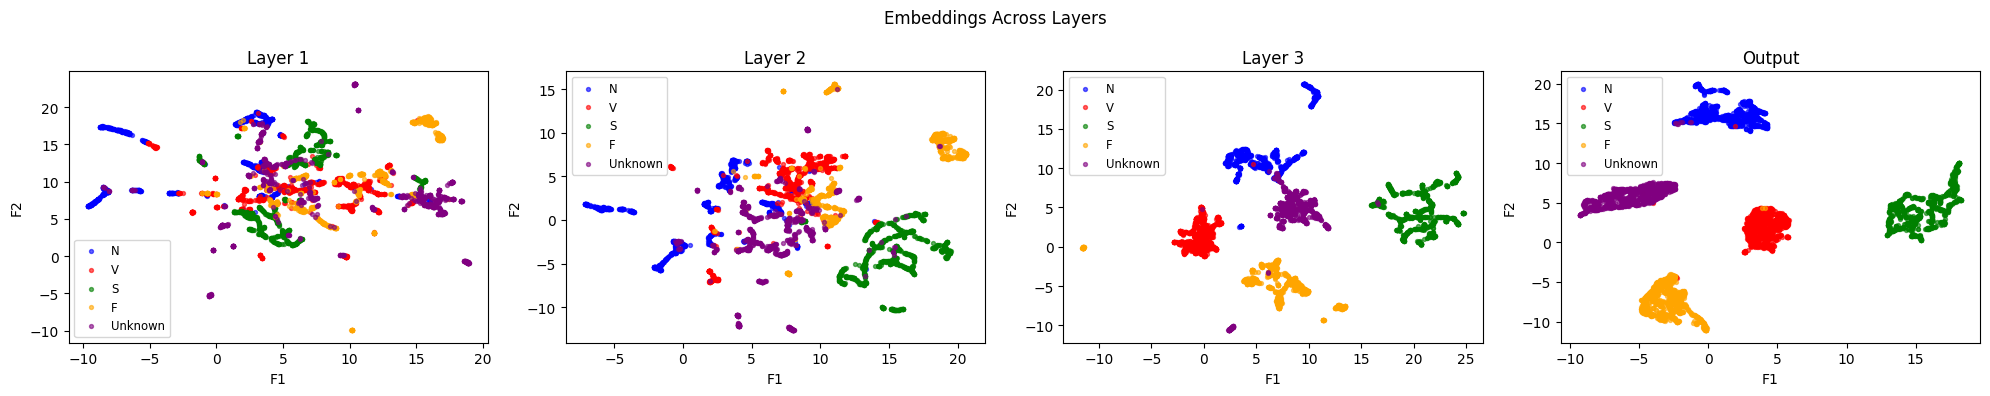

In [22]:

def plot_umap(feat_list, y, names=None, colors=None):
    y = y.cpu().numpy() if isinstance(y, torch.Tensor) else y
    classes = np.unique(y)
    if names is None:  names  = ['N', 'V', 'S', 'F', 'Unknown'][:len(classes)]
    if colors is None: colors = ['blue','red','green','orange','purple'][:len(classes)]

    fig, axs = plt.subplots(1, len(feat_list), figsize=(5*len(feat_list), 4))
    axs = np.atleast_1d(axs)

    for ax, (title, F) in zip(axs, feat_list):
        emb2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit_transform(F)
        for i, c in enumerate(classes):
            m = (y == c)
            ax.scatter(emb2d[m, 0], emb2d[m, 1], s=8, alpha=0.6, label=names[i], c=colors[i])
        ax.set_title(title)
        ax.set_xlabel('F1')
        ax.set_ylabel('F2')
        ax.legend(fontsize='small')

    plt.suptitle('Embeddings Across Layers')
    plt.tight_layout()
    plt.show()

plot_umap(feat_list, y_bal)


### Analyze

1. The clear separation between classes:

  - In the first layer (256D), the embeddings are very mixed, and the classes overlap without clear boundaries. In the second layer (128D), there is a small improvement, as some clusters start to form, but the classes are still not well separated. By the third layer (64D), clear separation appears, with most classes forming distinct clusters and visible gaps between them. Finally, in the output layer (5D), the classes are very well separated, each forming compact and isolated groups, which matches the goal of the final classification layer.

2. Notable changes in the distribution
  - Layer 1 → Layer 2: Distribution becomes slightly more structured, but overlap is still significant.

  - Layer 2 → Layer 3: A dramatic structural change occurs — clusters become distinct, showing that the network is learning to align features with class boundaries.

  - Layer 3 → Output: Clusters become even more compact and pushed further apart, showing strong class discrimination.

3. Are there any layers where the embeddings become less discriminative or more entangled?

  - No, the evolution is monotonic improvement. The embeddings do not regress into more entangled representations. Instead, they gradually transition from messy overlap (Layer 1) to clear clusters (Output).

  - However, Layer 1 is the least discriminative, showing that raw transformations do not yet capture class separation.


### Conclusion

The results show that the network slowly learns to separate the classes as the data moves through its layers. In the first layer, the embeddings are mixed together and do not show clear boundaries, so they are not very helpful for classification. In the second layer, some structure starts to appear, but there is still a lot of overlap between classes. In the third layer, the features become much clearer, and the classes are separated into distinct groups. In the output layer, the clusters are very compact and well divided, which allows the network to make accurate predictions.

This means that the early layers focus on simple and general features, while the deeper layers build stronger and more class-specific features. The change from messy to well-organized clusters shows that the model is learning to capture the important differences between arrhythmia types. This helps the network improve its ability to recognize each class and make correct predictions.
